1. Accuracy Comparison:

In [15]:
#Prepare the dataset
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

penguins = sns.load_dataset('penguins')
penguins = penguins[penguins['species'].isin(['Adelie', 'Gentoo'])]
penguins = penguins.dropna()

label_encoder = LabelEncoder()
penguins['sex'] = label_encoder.fit_transform(penguins['sex'])
penguins['island'] = label_encoder.fit_transform(penguins['island'])
penguins['species'] = label_encoder.fit_transform(penguins['species'])

x = penguins.drop('species', axis=1)
y = penguins['species']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)

In [16]:
#Naive Bayes Model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train)
bayes_train_pred = naive_bayes.predict(x_train)
bayes_test_pred = naive_bayes.predict(x_test)
bayes_train_acc = accuracy_score(y_train, bayes_train_pred)
bayes_test_acc = accuracy_score(y_test, bayes_test_pred)

In [17]:
#Logistic Regression Model
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)
log_reg_train_pred = log_reg.predict(x_train)
log_reg_test_pred = log_reg.predict(x_test)
log_reg_train_acc = accuracy_score(y_train, log_reg_train_pred)
log_reg_test_acc = accuracy_score(y_test, log_reg_test_pred)

In [18]:
print(f"Naive Bayes Training Acc: {bayes_train_acc:.2f}, Test Acc: {bayes_test_acc:.2f}")
print(f"Logistic Regression Training Acc: {log_reg_train_acc:.2f}, Test Acc: {log_reg_test_acc:.2f}")

Naive Bayes Training Acc: 1.00, Test Acc: 1.00
Logistic Regression Training Acc: 1.00, Test Acc: 1.00


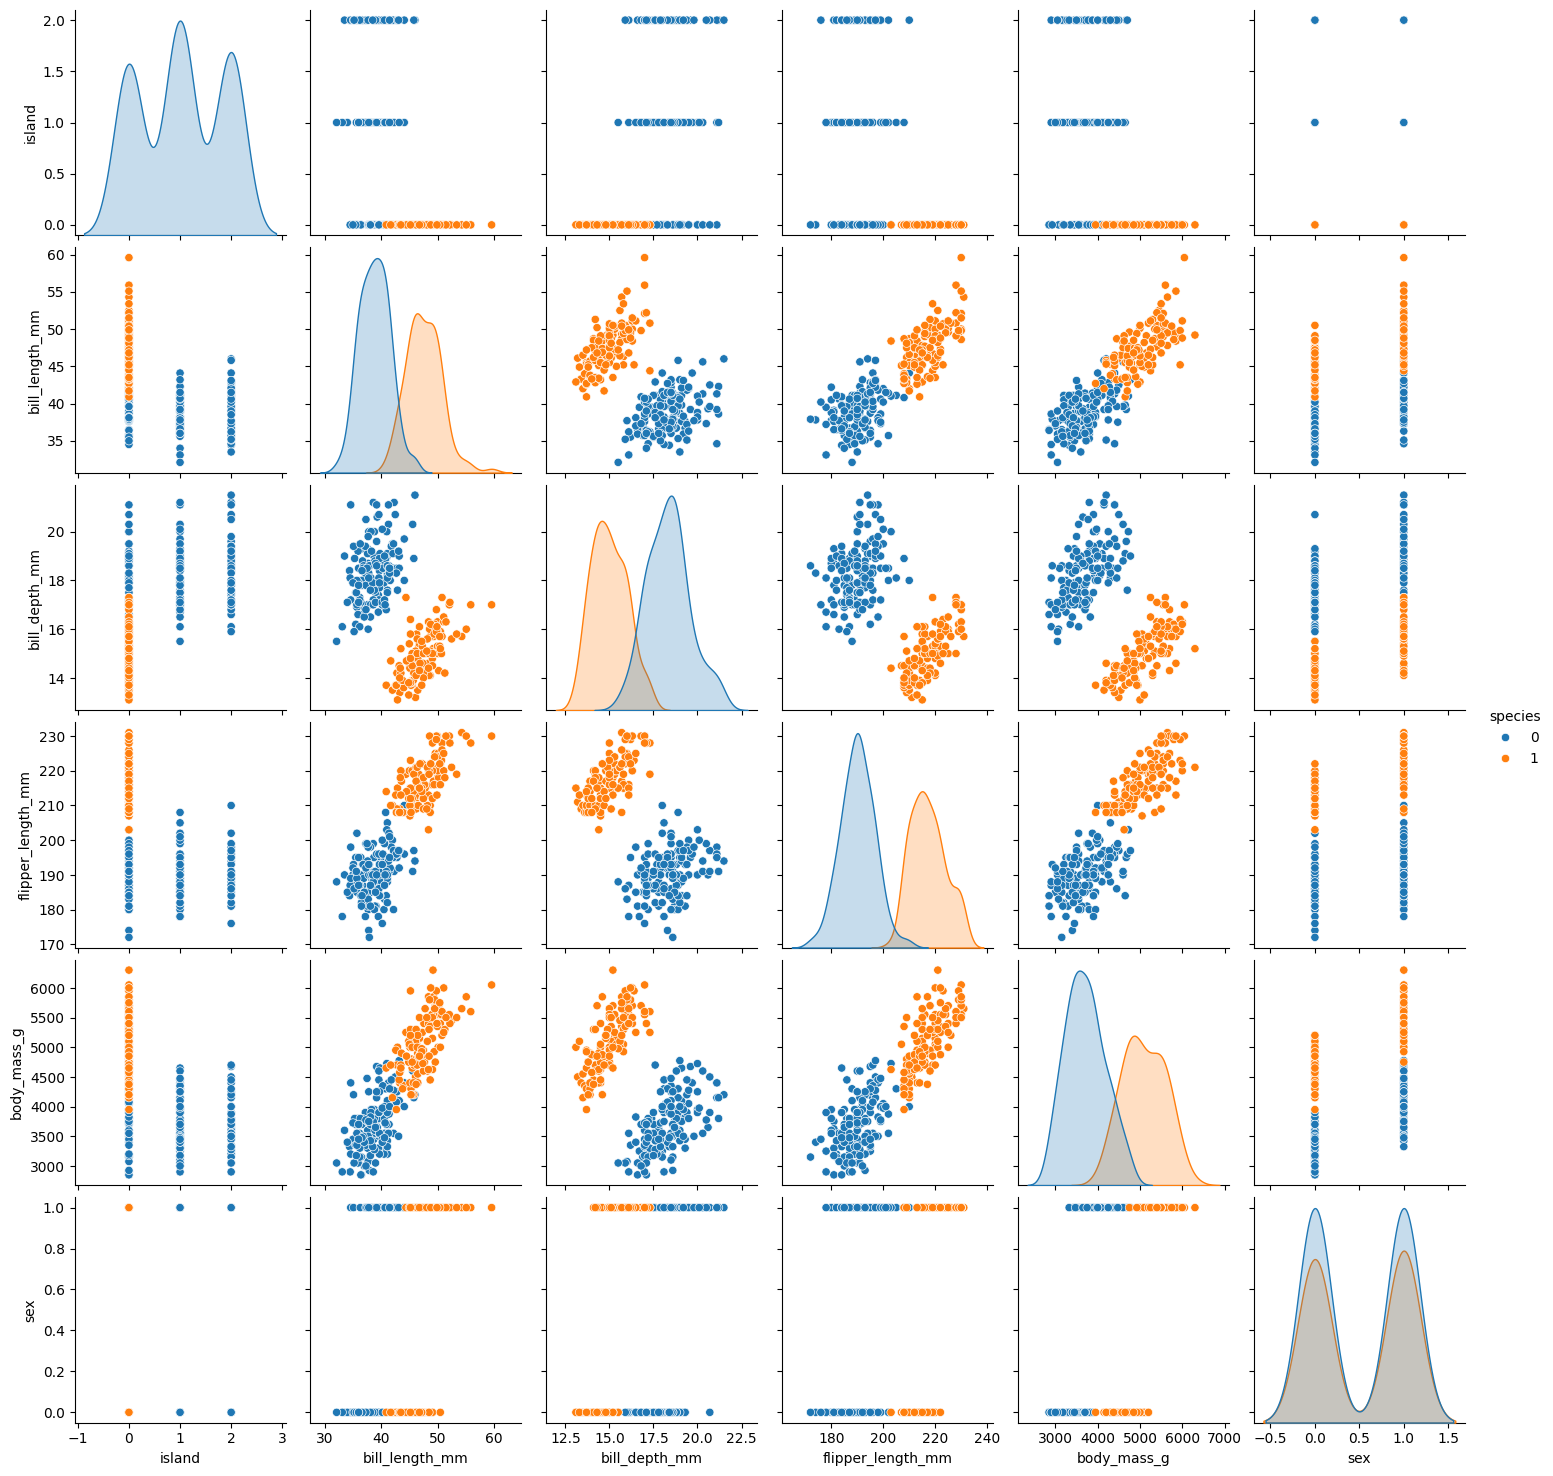

In [19]:
import matplotlib.pyplot as plt
sns.pairplot(penguins, hue='species')
plt.show()

The Naive Bayes and Logistic Regression models achieved 100% accuracy on both the training and testing datasets. 
As seen in the plots of the features above, the two penguin species have distinct characteristics.
Both models perform well on classifying this dataset because of its relative simplicity.

2. AUC (Area Under the ROC Curve) Comparison:

In [20]:
from sklearn.metrics import roc_auc_score

# Naive Bayes AUC
bayes_train_prob = naive_bayes.predict_proba(x_train)[:, 1]
bayes_test_prob = naive_bayes.predict_proba(x_test)[:, 1]
bayes_train_auc = roc_auc_score(y_train, bayes_train_prob)
bayes_test_auc = roc_auc_score(y_test, bayes_test_prob)

# Logistic Regression AUC
log_reg_train_prob = log_reg.predict_proba(x_train)[:, 1]
log_reg_test_prob = log_reg.predict_proba(x_test)[:, 1]
log_reg_train_auc = roc_auc_score(y_train, log_reg_train_prob)
log_reg_test_auc = roc_auc_score(y_test, log_reg_test_prob)

print(f"Naive Bayes Training AUC: {bayes_train_auc:.2f}, Test AUC: {bayes_test_auc:.2f}")
print(f"Logistic Regression Training AUC: {log_reg_train_auc:.2f}, Test AUC: {log_reg_test_auc:.2f}")

Naive Bayes Training AUC: 1.00, Test AUC: 1.00
Logistic Regression Training AUC: 1.00, Test AUC: 1.00


Both values yield an AUC value of 1.00. This means the models are able to perfectly separate the data based on the given features. Referring to the above plot, there are many cross features with zero overlap and have perfect separation between the species (Such as bill depth and body mass). Naive Bayes assumes feature independence while regression finds the boundary between the data. The penguins dataset for these two species is such that these models can distinguish the data well.

3. Lift and Gain Charts:

In [37]:
#Function to calculate Lift and Gain
import pandas as pd

def lift_gain(y_true, y_probs, num_deciles=10):
    data = pd.DataFrame({"positive": y_true, "y_prob": y_probs})
    data = data.sort_values("y_prob", ascending=False)
    data["decile"] = pd.qcut(data["y_prob"], q=num_deciles, labels=False, duplicates='drop')

    gain_values = []
    lift_values = []
    total_positives = sum(y_true)
    cumulative_positives = 0

    for i in range(num_deciles):
        decile_data = data[data["decile"] == i]
        
        if len(decile_data) == 0:
            gain_values.append(gain_values[-1] if gain_values else 0)
            lift_values.append(lift_values[-1] if lift_values else 1)
            continue

        num_positives = sum(decile_data["positive"])
        cumulative_positives += num_positives

        gain = cumulative_positives / total_positives
        lift = (num_positives / len(decile_data)) / (total_positives / len(y_true))
        
        gain_values.append(gain)
        lift_values.append(lift)
    
    return gain_values, lift_values

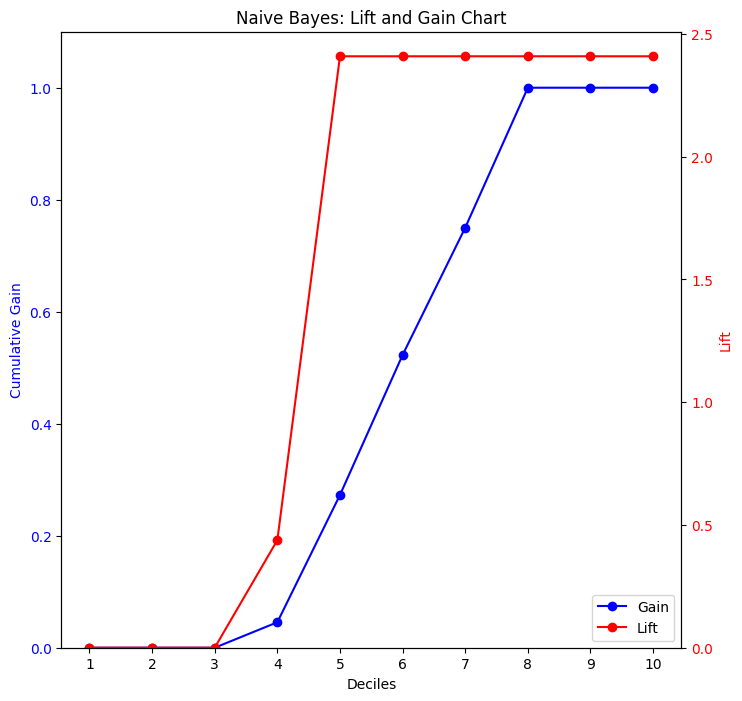

In [48]:
#Plot Naive Bayes Lift and Gain Chart
import numpy as np

bayes_gain, bayes_lift = lift_gain(y_test, bayes_test_prob)
deciles = np.arange(1, len(bayes_gain) + 1)

bayes_plot, bayes_y1 = plt.subplots(figsize=(8, 8))
bayes_y2 = bayes_y1.twinx()

bayes_y1.set_title("Naive Bayes: Lift and Gain Chart")
bayes_y1.set_xlabel("Deciles")
bayes_y1.set_ylabel("Cumulative Gain", color="blue")
bayes_y2.set_ylabel("Lift", color="red")

bayes_y1.plot(deciles, bayes_gain, label="Gain", marker="o", linestyle="-", color="blue")
bayes_y2.plot(deciles, bayes_lift, label="Lift", marker="o", linestyle="-", color="red")

bayes_y1.tick_params(axis='y', labelcolor="blue")
bayes_y2.tick_params(axis='y', labelcolor="red")

bayes_y1.set_ylim(0, 1.1)
bayes_y2.set_ylim(0, max(nb_lift) + 0.1)

bayes_y1.set_xticks(deciles)

bayes_line1, bayes_label1 = bayes_y1.get_legend_handles_labels()
bayes_line2, bayes_label2 = bayes_y2.get_legend_handles_labels()
bayes_y1.legend(bayes_line1 + bayes_line2, bayes_label1 + bayes_label2, loc="lower right")

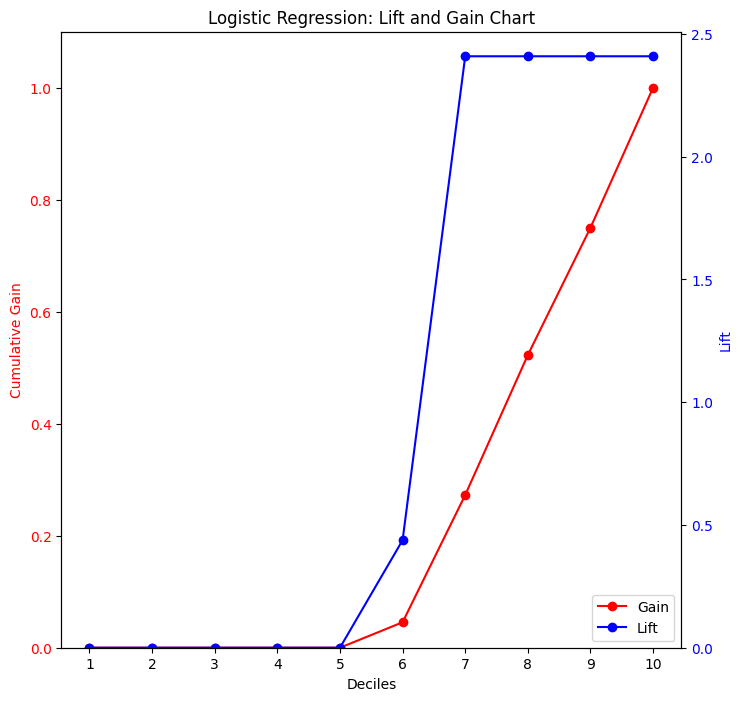

In [50]:
#Plot Logistic Regression Lift and Gain Chart
log_gain, log_lift = lift_gain(y_test, log_reg_test_prob)

log_plot, log_y1 = plt.subplots(figsize=(8, 8))
log_y2 = log_y1.twinx()

log_y1.set_title("Logistic Regression: Lift and Gain Chart")
log_y1.set_xlabel("Deciles")
log_y1.set_ylabel("Cumulative Gain", color="red")
log_y2.set_ylabel("Lift", color="blue")

log_y1.plot(deciles, log_gain, label="Gain", marker="o", linestyle="-", color="red")
log_y2.plot(deciles, log_lift, label="Lift", marker="o", linestyle="-", color="blue")

log_y1.tick_params(axis='y', labelcolor="red")
log_y2.tick_params(axis='y', labelcolor="blue")

log_y1.set_ylim(0, 1.1)
log_y2.set_ylim(0, max(lr_lift) + 0.1)

log_y1.set_xticks(deciles)

log_line1, log_label1 = log_y1.get_legend_handles_labels()
log_line2, log_label2 = log_y2.get_legend_handles_labels()
log_y1.legend(log_line1 + log_line2, log_label1 + log_label2, loc="lower right")

Analyzing the lift and gain charts: Both models have a steep rise in gain and lift with the Naive Bayes model starting to rise at 3 deciles and the logical regression starting at 5 deciles. The plots are exactly identical except Naive Bayes starts to increase 2 deciles earlier and reaches a gain of 1.0 at decile 8 while logistic regression takes until decile 10 to reach a gain of 1.0. This means that 100% of the dataset has to be included before all the positives are found in the case of a logistic regression model while the naive bayes model can find all the positives with the top 80% of the ranked predictions. Based on the graphs, both models rank predicted probabilities effectively. However, in terms of prioritizing the classification of the two species, naives bayes performs better.

4. Model Performance Comparison:

Based on the metrics of accuracy and AUC, both models have perfect performance and are equally effective in terms of classification results. Score of 1.00 for accuracy and AUC suggests that the data is trivially separable for the models. The lift and gain charts illustrate a very similar performance for both models, with the Naive Bayes model being more effective at capturing all the positives with a smaller portion of the population (80% as opposed to 100%). 

In [26]:
#Prepare the dataset
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler

mnist = fetch_openml('mnist_784', version=1, parser='auto')
x, y = mnist.data, mnist.target.astype(int) 

x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    train_size=0.1, 
    test_size=0.05, 
    stratify=y  
)

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [28]:
#Naive Bayes Model
naive_bayes = GaussianNB()
naive_bayes.fit(x_train_scaled, y_train)
bayes_test_pred = naive_bayes.predict(x_test_scaled)  
bayes_test_acc = accuracy_score(y_test, bayes_test_pred) 

In [29]:
#Logistic Regression Model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train_scaled, y_train)
log_reg_test_pred = log_reg.predict(x_test_scaled)
log_reg_test_acc = accuracy_score(y_test, log_reg_test_pred)

In [31]:
print("MNIST (handwritten digits) Results:")
print(f"Naive Bayes Test Acc: {bayes_test_acc:.3f}")
print(f"Logistic Regression Test Acc: {log_reg_test_acc:.3f}")

MNIST (handwritten digits) Results:
Naive Bayes Test Acc: 0.565
Logistic Regression Test Acc: 0.908


Compare and discuss:

Two species penguin dataset:
-Structured meaningful data
-binary classes with minimal overlap
-Low dimensionality

MNIST Handwritten Digits dataset:
-image pixel data
-complex overlapping classes
-High dimensionality

Naive Bayes Model
Penguins Acc: 1.00
MNIST Acc: .565
Naive Bayes performs very poorly on the MNIST dataset as the core assumption of feature independence does not hold because the pixels are correlated and form shapes. In contrast, penguin body measurements are not as deeply correlated and can be used to classify species.

Logistic Regression Model:
Penguins Acc: 1.00
MNIST Acc: 0.908
Logistic Regression model performs well on the MNIST dataset as it does not assume feature independence. These results show that the MNIST digits are linearly separable in high dimensional space with an accuracy of 90%.

Generative models such as Naive Bayes perform better on simpler, low-dimensional datasets where features are independent. Discriminative models such as Logistic Regression perform well regardless of feature correlation on both simple and complex tasks however, they are not able to fully capture the data as they struggle with patterns that are not linear.
